In [365]:
import os, sys
import numpy as np
from astropy import units, constants
from astropy.io import fits
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize, curve_fit
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks, gaussian
from scipy.interpolate import interp1d
from lmfit import Model
from matplotlib.gridspec import GridSpec
import lmfit
from lightkurve.lightcurve import LightCurve

from stella.utils import flare_lightcurve


COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'


%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

## PROPOSAL ID 16164
plt.rcParams['font.size']=18

def load_data(path):
    wavelength, flux, err = load_binned_data(os.path.join(path,'interp_between_1.npy'))

    times = np.load(os.path.join(path,'times.npy'))
    orbits = np.load(os.path.join(path,'orbits.npy'))

    wavelength = np.full(flux.shape, wavelength)
    return wavelength, flux, err, times, orbits

w, f, e, t, o = load_data(path='/Users/arcticfox/Documents/AUMic/1s')
_,_,_, t0, _ = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced')

_, flare_orbits, flare_mask = np.load('/Users/arcticfox/Documents/AUMic/flare_mask2.npy',
                                      allow_pickle=True)

parula = np.load('/Users/arcticfox/parula_colors.npy')

distance = (9.72*units.pc).to(units.cm)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [366]:
time=t[12:]-t0[0]

In [391]:
letter = 'a'
path = '/Users/arcticfox/Documents/AUMic/1s/reduced2/{}'.format(letter)
files = np.sort([os.path.join(path, i) for i in os.listdir(path) if i.endswith('x1d.fits')])
if letter == 'a':
    files = files[12:]

In [392]:
for i in tqdm_notebook(range(len(files))):
    hdu = fits.open(files[i])
    if i == 0:
        countsa = np.zeros((2, len(time), len(hdu[1].data['WAVELENGTH'][0])))
    try:
        if hdu[1].data['WAVELENGTH'][0][0] < 1200:
            countsa[0][i] = hdu[1].data['WAVELENGTH'][0]
            countsa[1][i] = hdu[1].data['NET'][0]
        else:
            countsa[0][i] = hdu[1].data['WAVELENGTH'][1]
            countsa[1][i] = hdu[1].data['NET'][1]
    except:
        countsa[0][i] = hdu[1].data['WAVELENGTH'][0]
        countsa[1][i] = hdu[1].data['NET'][0]
    hdu.close()

/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_81759/479660135.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(files))):


  0%|          | 0/1200 [00:00<?, ?it/s]

In [393]:
counts = np.zeros(np.shape(countsa))
interpwave = np.linspace(np.nanmax(countsa[0][:,0]), np.nanmin(countsa[0][:,-1]),
                          len(countsa[0][0]))
for i in range(len(counts[0])):
    interp = interp1d(countsa[0][i], countsa[1][i])
    counts[0][i] = interpwave + 0.0
    counts[1][i] = interp(interpwave) + 0.0 

In [394]:
timebins = np.arange(0,len(time)+3,3)

time_summed = np.zeros((len(timebins), len(countsa[0][0])))
for i in range(len(timebins)-1):
    time_summed[i] = np.nansum(countsa[1][timebins[i]:timebins[i+1]], axis=0)

(10.0, 820.0)

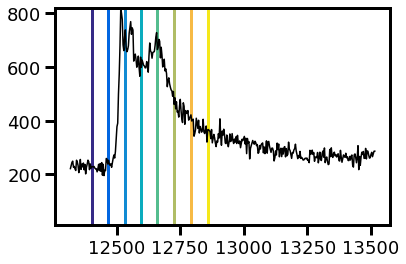

In [395]:
plt.plot(time[timebins[:-1]], np.nansum(time_summed, axis=1)[:-1], 'k')
x=0
xadd=35

if letter=='a':
    q = (interpwave>1221) & (interpwave<1230)
else:
    q = (interpwave>1203) & (interpwave<1210)
linspace = np.linspace(50,len(timebins)-120,5,dtype=int)
linspace = np.linspace(28,180,8, dtype=int)

for i in linspace:
    plt.vlines(time[timebins[:-1]][i], 0, 1000, color=parula[x], lw=3)
    x += xadd
plt.ylim(10,820)

(0.0, 15.0)

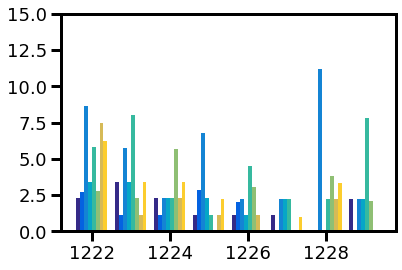

In [396]:
if letter == 'a':
    bins=np.arange(1221.5, 1230.5, 1)
else:
    bins=np.arange(1203-0.5, 1207.5, 1) 
out = plt.hist(counts[0][linspace][:,q].T, bins=bins, 
         weights=time_summed[linspace][:,q].T,
         density=False,
         lw=4, 
        color=parula[np.linspace(0,len(parula)-30,len(linspace), dtype=int)])
plt.ylim(0,15)

In [397]:
def histograms_only(counts, start_wavelength=1221.5):
    plt.figure(figsize=(14,4))

    fig, axes = plt.subplots(ncols=1, nrows=len(linspace), 
                             figsize=(8,20), sharey=True)
    axes = axes.reshape(-1)

    for i in range(len(axes)):
        out = axes[i].hist(counts[0][linspace][:,q].T, bins=bins, 
                       weights=time_summed[linspace][:,q].T,#/1e-12, 
                       density=False, #histtype='step',
                       lw=4, 
                       color=parula[np.linspace(0,len(parula)-30,len(linspace),dtype=int)])
        if i == 2:
            axes[i].set_ylabel('Counts [e s$^{-1}$]')
        if i == 7:
            axes[i].set_xlabel('Time [s]')
        axes[i].set_xlim(start_wavelength+i,start_wavelength+1+i)
        axes[i].set_xticks(np.linspace(start_wavelength+0.09+i,
                                       start_wavelength+1-0.09+i,len(linspace)))
        axes[i].set_xticklabels(timebins[linspace])
        axes[i].text(s=r'$\lambda$ = {} $\AA$'.format(start_wavelength+0.5+i), 
                     x=start_wavelength+0.05+i, y=7)
        if i < 4:
            axes[i].set_xticklabels([])
    plt.ylim(0,15)
    plt.show()
    return

<Figure size 1008x288 with 0 Axes>

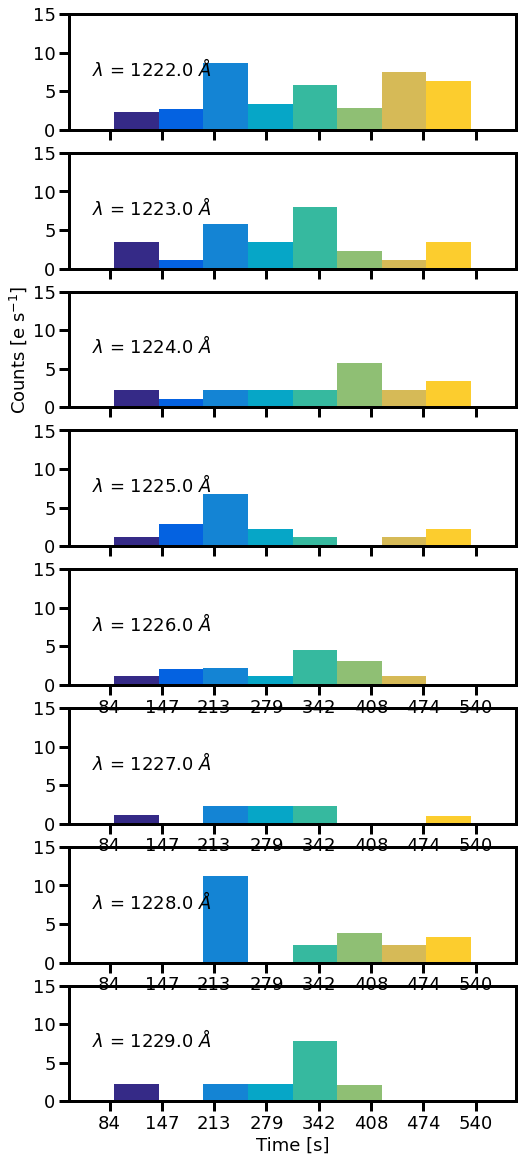

In [398]:
if letter=='a':
    histograms_only(counts)#, start_wavelength=1200-0.5)#1221.5)
else:
    histograms_only(counts, start_wavelength=1203-0.5)#1221.5)

/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_81759/3635133052.py:62: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig = plt.savefig('/Users/arcticfox/Desktop/Orrall-Zirker_{}.png'.format(suffix), dpi=300,


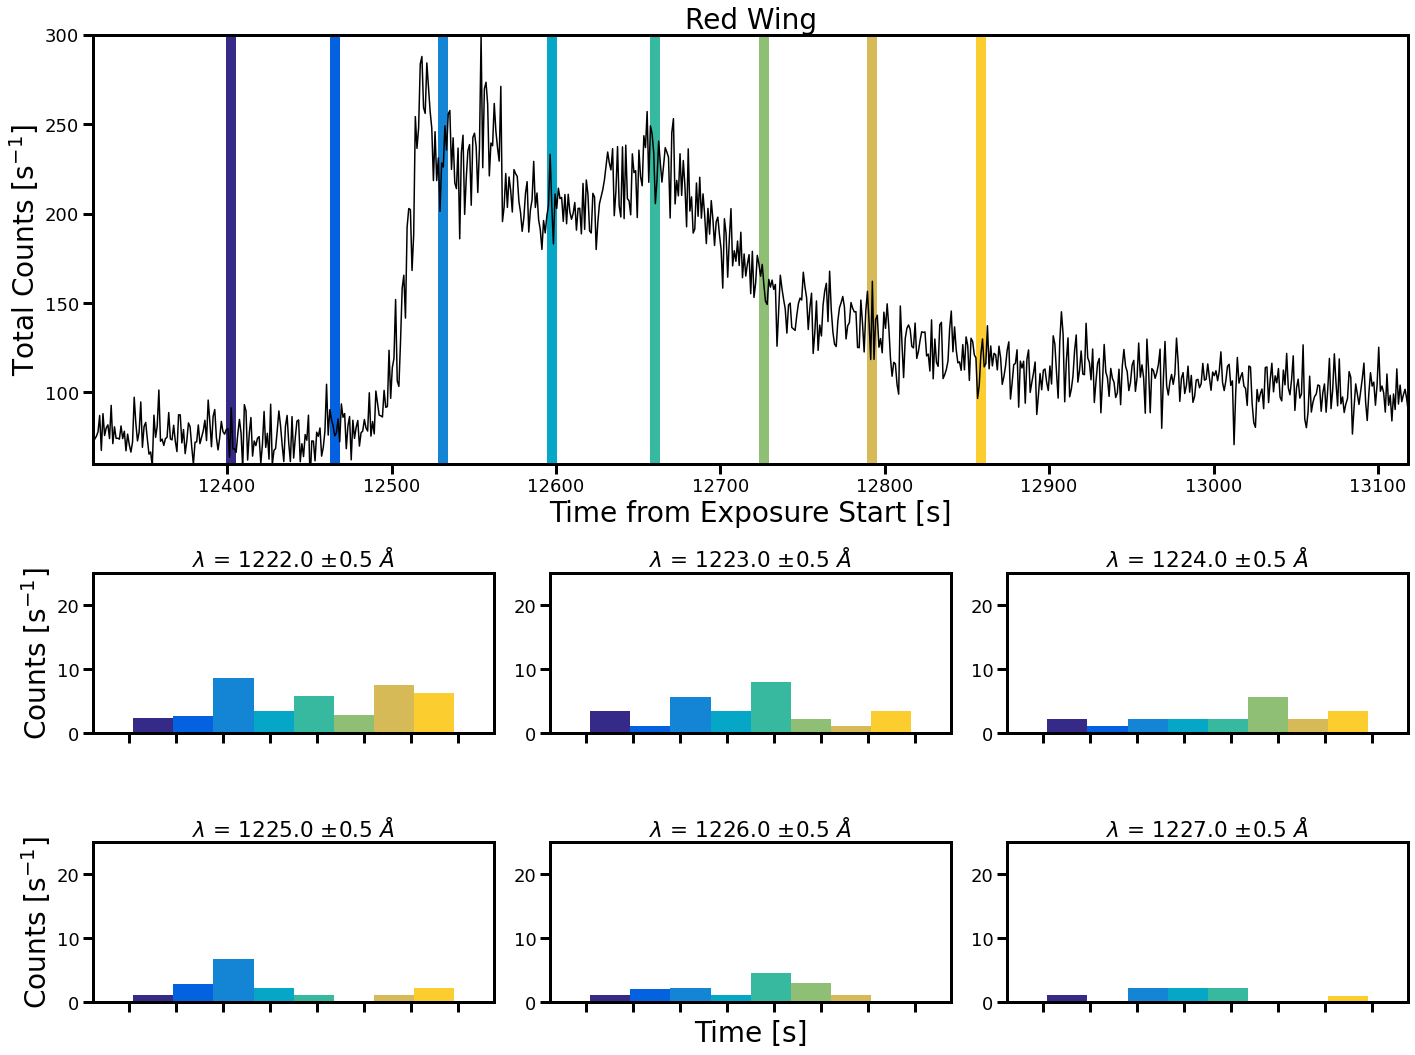

In [399]:
def main_figure(counts, start_wavelength=1221.5, ylim=[60,300]):

    fig = plt.figure(tight_layout=True, figsize=(20,15))
    fig.set_facecolor('w')
    gs = GridSpec(ncols=3, nrows=4)

    ax = fig.add_subplot(gs[0:2, :])

    ax.plot(time, np.nansum(counts[1],axis=1), 'k')
            #np.trapz(counts, x=fwc.wavelength, axis=1), 'k')
    x=0
    for i in linspace:
        ax.vlines(time[timebins[:-1]][i], 0, 10000, 
                  color=parula[np.linspace(0,len(parula)-30,len(linspace),dtype=int)][x],
                  lw=10)
        x += 1

    ax.set_ylim(ylim)
    ax.set_ylabel('Total Counts [s$^{-1}$]', fontsize=28)
    ax.set_xlabel('Time from Exposure Start [s]', fontsize=28)
    ax.set_xlim(time[0],time[int(len(time)/1.5)])
    
    axes = []
    for i in range(3):
        axes.append(fig.add_subplot(gs[-2,i]))
    for i in range(3):
        axes.append(fig.add_subplot(gs[-1,i]))

    for i in range(len(axes)):
        out = axes[i].hist(counts[0][linspace][:,q].T, bins=bins, 
                           weights=time_summed[linspace][:,q].T,#/1e-12, 
                           density=False, #histtype='step',
                           lw=4, 
                           color=parula[np.linspace(0,len(parula)-30,len(linspace),dtype=int)])
        if i == 0 or i==3:
            axes[i].set_ylabel('Counts [s$^{-1}$]', fontsize=28)
        if i == 4:
            axes[i].set_xlabel('Time [s]', fontsize=28)

        axes[i].set_xlim(start_wavelength+i,start_wavelength+1+i)
        axes[i].set_xticks(np.linspace(start_wavelength+0.09+i,
                                       start_wavelength+1-0.09+i,len(linspace)))
        axes[i].set_xticklabels([])
        #axes[i].set_xticklabels(timebins[linspace])

        axes[i].set_title(r'$\lambda$ = {} $\pm 0.5$ $\AA$'.format(start_wavelength+0.5+i))
        axes[i].set_ylim(0,25)
        axes[i].set_rasterized(True)
    return fig

save = True

if letter == 'b':
    fig = main_figure(counts, start_wavelength=1203-0.5, ylim=[0,220])
    fig.axes[0].set_title('Blue Wing', fontsize=28)
    suffix = 'blue'
else:
    fig = main_figure(counts)
    fig.axes[0].set_title('Red Wing', fontsize=28)
    suffix = 'red'
if save:
    fig = plt.savefig('/Users/arcticfox/Desktop/Orrall-Zirker_{}.png'.format(suffix), dpi=300,
                      rasterize=True, bbox_inches='tight')

In [400]:
np.save('/Users/arcticfox/Documents/AUMic/1s/counts{}.npy'.format(letter), 
        {'counts':counts, 
         'linspace':linspace,
         'time_summed':time_summed,
         'timebins':timebins,
         'bins':bins})

## Look at -- F(1205.67-1208.67)/F(1222.67-1225.67)

In [401]:
q1 = ((w[0]>=1205.) & (w[0]<=1208.))
q2 = ((w[0]>=1222.) & (w[0]<=1225.))
trap1 = np.trapz(f[:,q1], x=w[:,q1], axis=1)
trap2 = np.trapz(f[:,q2], x=w[:,q2], axis=1)
frac = trap1/trap2

/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_81759/1592759298.py:5: RuntimeWarning: divide by zero encountered in true_divide
  frac = trap1/trap2
/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_81759/1592759298.py:5: RuntimeWarning: invalid value encountered in true_divide
  frac = trap1/trap2


Text(0.5, 0, 'Time from Exposure Start [s]')

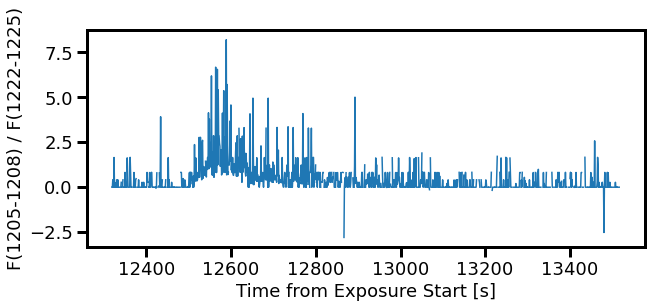

In [402]:
fig = plt.figure(figsize=(10,4))
fig.set_facecolor('w')
plt.plot(time, frac)
plt.ylabel('F(1205-1208) / F(1222-1225)')
plt.xlabel('Time from Exposure Start [s]')
#plt.savefig('/Users/arcticfox/Desktop/flux_ratio.png', dpi=250, rasterize=True,
#            bbox_inches='tight')

## Comparing Counts

In [403]:
countsa = np.load('/Users/arcticfox/Documents/AUMic/1s/countsa.npy', allow_pickle=True).tolist()
countsb = np.load('/Users/arcticfox/Documents/AUMic/1s/countsb.npy', allow_pickle=True).tolist()

(-0.1, 2.3)

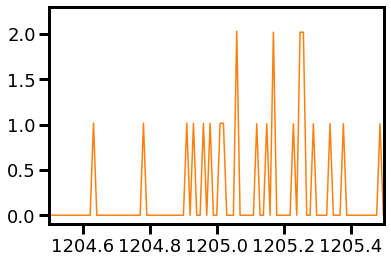

In [404]:
plt.plot(countsa['counts'][0][0],
         countsa['time_summed'][countsa['linspace'][2]])
plt.plot(countsb['counts'][0][0],
         countsb['time_summed'][countsb['linspace'][2]])
plt.xlim(1204.5,1205.5)
plt.ylim(-0.1,2.3)

0 1203.0 3.5053433179855347
1 1204.0 6.480389595031738
2 1205.0 23.28202974796295
3 1206.0 5.0490957498550415


IndexError: index 5 is out of bounds for axis 0 with size 5

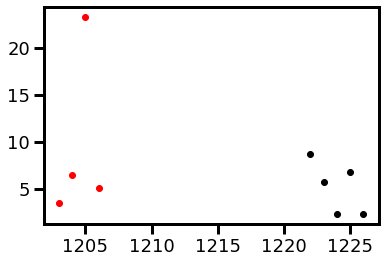

In [405]:
for i in range(len(countsa['bins'])-1):
    q = ((countsa['counts'][0][0] >= countsa['bins'][i]) &
         (countsa['counts'][0][0] < countsa['bins'][i+1]))
    center = (countsa['bins'][i+1]+countsa['bins'][i])/2
    plt.plot(center, 
             np.nansum(countsa['time_summed'][countsa['linspace'][2]][q]), 'ko')
    
    q = ((countsb['counts'][0][0] >= countsb['bins'][i]) &
         (countsb['counts'][0][0] < countsb['bins'][i+1]))
    center = (countsb['bins'][i+1]+countsb['bins'][i])/2
    plt.plot(center, 
             np.nansum(countsb['time_summed'][countsb['linspace'][2]][q]), 'ro')
    print(i, center, np.nansum(countsb['time_summed'][countsb['linspace'][2]][q]))

In [309]:
countsb['bins'][i], countsb['bins'][i+1]

(1206.5, 1207.5)